In [8]:
# !pip install kagglehub

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")

# print("Path to dataset files:", path)

In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("noamsegal/affectnet-training-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\kainak0\.cache\kagglehub\datasets\noamsegal\affectnet-training-data\versions\3


In [12]:
!ls -la {path}

total 14552
drwxr-xr-x 1 kainak0 197609       0 Oct 21 21:48 .
drwxr-xr-x 1 kainak0 197609       0 Oct 21 21:47 ..
drwxr-xr-x 1 kainak0 197609       0 Oct 21 21:47 anger
drwxr-xr-x 1 kainak0 197609       0 Oct 21 21:47 contempt
drwxr-xr-x 1 kainak0 197609       0 Oct 21 21:48 disgust
drwxr-xr-x 1 kainak0 197609       0 Oct 21 21:48 fear
drwxr-xr-x 1 kainak0 197609       0 Oct 21 21:48 happy
-rw-r--r-- 1 kainak0 197609 1525091 Oct 21 21:48 labels.csv
drwxr-xr-x 1 kainak0 197609       0 Oct 21 21:48 neutral
drwxr-xr-x 1 kainak0 197609       0 Oct 21 21:48 sad
drwxr-xr-x 1 kainak0 197609       0 Oct 21 21:48 surprise


In [13]:
print(path)

C:\Users\kainak0\.cache\kagglehub\datasets\noamsegal\affectnet-training-data\versions\3


In [52]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import random_split,Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [15]:
classes = os.listdir(path)
# label = classes.pop(6)

In [16]:
classes

['anger',
 'contempt',
 'disgust',
 'fear',
 'happy',
 'labels.csv',
 'neutral',
 'sad',
 'surprise']

In [17]:
classes.remove('labels.csv')

In [18]:
# path_label = os.path.join(path,label)
# path_label

In [19]:
# !mv {path_label} /root/.cache/kagglehub/datasets/noamsegal/affectnet-training-data/versions/

In [20]:
len(classes)

8

In [21]:
# classes = os.listdir(path)
classes_size = []

for i in range(len(classes)):
    size = len(os.listdir(path + '/' + classes[i]))
    print(f"# of images in class test {classes[i]}: {size}")
    classes_size.append(size)
print(f"total : {sum(classes_size)}")

# of images in class test anger: 3218
# of images in class test contempt: 2871
# of images in class test disgust: 2477
# of images in class test fear: 3176
# of images in class test happy: 5044
# of images in class test neutral: 5126
# of images in class test sad: 3091
# of images in class test surprise: 4039
total : 29042


In [22]:
# train = os.path.join(path, 'train')
# test = os.path.join(path, 'test')
# classes_train = os.listdir(train)
# classes_train_size = []
# classes_test = os.listdir(test)
# classes_test_size = []

# for i in range(len(classes_train)):
#     size = len(os.listdir(train+'/'+classes_train[i]))
#     print(f"# of images in class train {classes_train[i]}: {size}")
#     classes_train_size.append(size)
# print(f"total : {sum(classes_train_size)}")
# for i in range(len(classes_test)):
#     size = len(os.listdir(test+'/'+classes_test[i]))
#     print(f"# of images in class test {classes_test[i]}: {size}")
#     classes_test_size.append(size)
# print(f"total : {sum(classes_test_size)}")



In [23]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return torch.relu(self.bn(self.conv(x)))

In [24]:
class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()
        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=(1, 1))

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=(1, 1)),
            conv_block(red_3x3, out_3x3, kernel_size=(3, 3), padding=(1, 1)),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=(1, 1)),
            conv_block(red_5x5, out_5x5, kernel_size=(5, 5), padding=(2, 2)),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            conv_block(in_channels, out_1x1pool, kernel_size=(1, 1)),
        )

    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)

In [25]:
class GoogleNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=8):  # num_classes ajustado para CIFAR-10
        super(GoogleNet, self).__init__()

        self.conv1 = conv_block(in_channels=in_channels, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2 = conv_block(in_channels=64, out_channels=192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        #self.avgpool = nn.AvgPool2d(kernel_size=2, stride=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [26]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [27]:
# Definir transformaciones de preprocesamiento
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Cambiar el tamaño de las imágenes
    transforms.ToTensor(),          # Convertir las imágenes en tensores
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización
])

# Cargar el dataset

dataset = datasets.ImageFolder(os.path.join(path), transform=transform)

train_size, val_size = int(0.8 * len(dataset)), int(0.2 * len(dataset))
val_size = val_size +1

train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) # stratified split is better

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # shuffle to avoid memorization (overfitting)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GoogleNet(in_channels = 3,num_classes = 8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
# Lists to store loss and accuracy values
train_losses = []
test_accuracies = []
model.train()

num_epochs = 20

for epoch in range(num_epochs):

    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')


KeyboardInterrupt: 

In [ ]:
# !ls -la {'/content/drive/MyDrive/Parcial_redes/fer_py/models'}

In [37]:
path = 'models/GoogleNet_FER_ep20_67.pth'

In [ ]:
# Testing the model

model = GoogleNet().to(device)
model.load_state_dict(torch.load(path))

C:\Users\kainak0\AppData\Local\Temp\ipykernel_37596\3067009445.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<All keys matched successfully>

In [35]:

model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the 10,000 test images: {100 * correct / total:.2f}%')

Accuracy of the model on the 10,000 test images: 88.67%


In [ ]:
# os.makedirs('/models', exist_ok= True)

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/Parcial_redes/fer_py/models/')

In [ ]:
# torch.save(model.state_dict(), 'models/GoogleNet_FER.pth')

C:\Users\kainak0\AppData\Local\Temp\ipykernel_37596\3440687834.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)


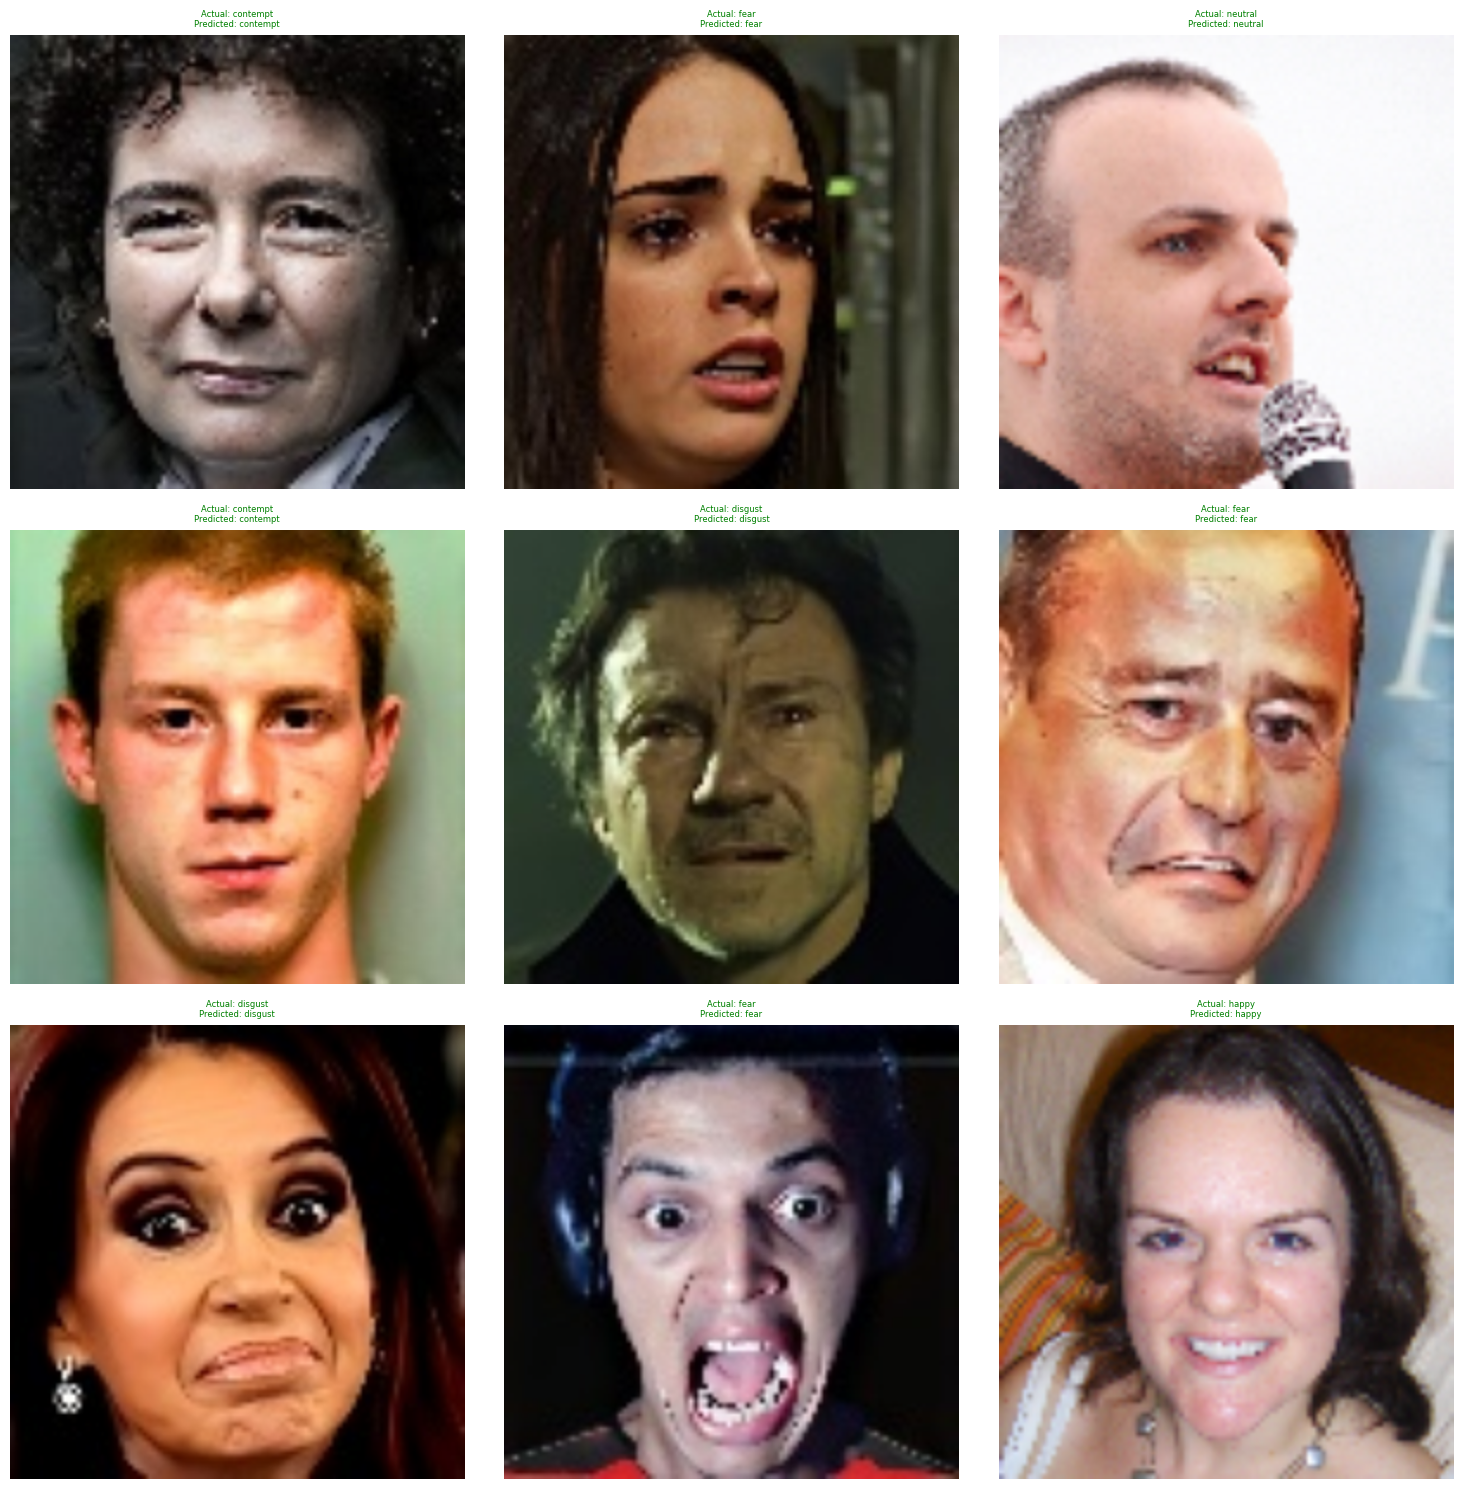

In [69]:
import matplotlib.pyplot as plt
import random
import torchvision

def show_random_test_predictions(model, dataloader, class_names, num_images=9):
    model.eval()
    images_shown = 0
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()

    all_images = []
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_images.extend(inputs.cpu())
            all_labels.extend(labels.cpu())
            all_preds.extend(preds.cpu())

    combined = list(zip(all_images, all_labels, all_preds))
    random.shuffle(combined)

    selected_images = random.sample(combined, min(num_images, len(combined)))

    for idx, (img, label, pred) in enumerate(selected_images):
        ax = axes[images_shown]
        ax.axis('off')

        img = img.numpy().transpose((1, 2, 0))
        img = np.clip((img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406], 0, 1)

        ax.imshow(img)

        predicted_class = class_names[pred]
        actual_class = class_names[label]
        title = f'Actual: {class_names[label]}\nPredicted: {class_names[pred]}'

        if predicted_class == actual_class:
            ax.set_title(title, color='green',fontsize=6)
        else:
            ax.set_title(title, color='red',fontsize=6)

        images_shown += 1
        if images_shown == num_images:
            break

    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# path = '/content/drive/MyDrive/Parcial_redes/fer_py/models/GoogleNet_FER_ep20_67.pth'
model = GoogleNet().to(device)
state_dict = torch.load(path)
model.load_state_dict(state_dict)
# model.load_state_dict(torch.load(path))
show_random_test_predictions(model, val_loader, classes, num_images=9)

In [ ]:
def load_and_preprocess_image(image_path):
    """
    Load and preprocess an image for emotion classification.
    """
    # Standard transformations for face emotion recognition
    transform = transforms.Compose([
        transforms.Resize((48, 48)),  # Common size for emotion detection
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Load and convert image
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0) 


In [ ]:
def apply_classifier(clf,xTrain,xTest,yTrain,yTest):

    clf.fit(xTrain, yTrain) #Entrenamiento del modelo
    predictions = clf.predict(xTest) #Validación sobre la data de testing
    conf_mtx = confusion_matrix(yTest,predictions) #Matriz de confusión de la data de testing real con la predicha

    f, axes = plt.subplots(ncols=2, figsize=(15, 5)) #Definición del área de visualización (2 gráficas)

    sns.heatmap(conf_mtx,annot=True,cbar = False,fmt = "g",ax = axes[0])#definición del formato de la matriz de confusión
    axes[0].set_xlabel('Predicted labels') #Titulo del eje x de la matriz de confusión
    axes[0].set_ylabel('True labels') #Titulo del eje y de la matriz de confusión
    axes[0].set_title('Confusion Matrix Test'); #Titulo de la matriz de confusión
    axes[0].xaxis.set_ticklabels(['Normal', 'Outer Race']); #distribución de los resultados en la matriz de confusión del eje x
    axes[0].yaxis.set_ticklabels(['Normal', 'Outer Race']); #distribución de los resultados en la matriz de confusión del eje y

    print(classification_report(yTest,predictions)) #mostrar resultados

    roc_auc = roc_auc_score(yTest,predictions) #definición del cálculo del auc
    print ("AUC ROC : ",roc_auc) #mostrar el resultado

    fpr, tpr,_ = roc_curve(yTest, predictions) #Función para armar la curva ROC
    #fpr : false positive rate
    #tpr : true positive rate
    axes[1].plot(fpr,tpr,label= "auc="+str(roc_auc)); #código para mostrar el resultado del auc en la gráfica
    axes[1].plot([0, 1], [0, 1]) #código del formato de la gráfica
    plt.xlabel('False Positive Rate') #título del eje x
    plt.ylabel('True Positive Rate') #título del eje y
    plt.title('ROC') #título del gráfico

In [ ]:
decision_tree = model # Definir nuestro modelo
apply_classifier(decision_tree,X_train, X_test, y_train, y_test) # Aplicar la funcion que hemos construido